In [1]:
import numpy as np
import pandas as pd
from obspy import read
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import cm
import os
import cv2 as cv
from scipy import signal

In [2]:
cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

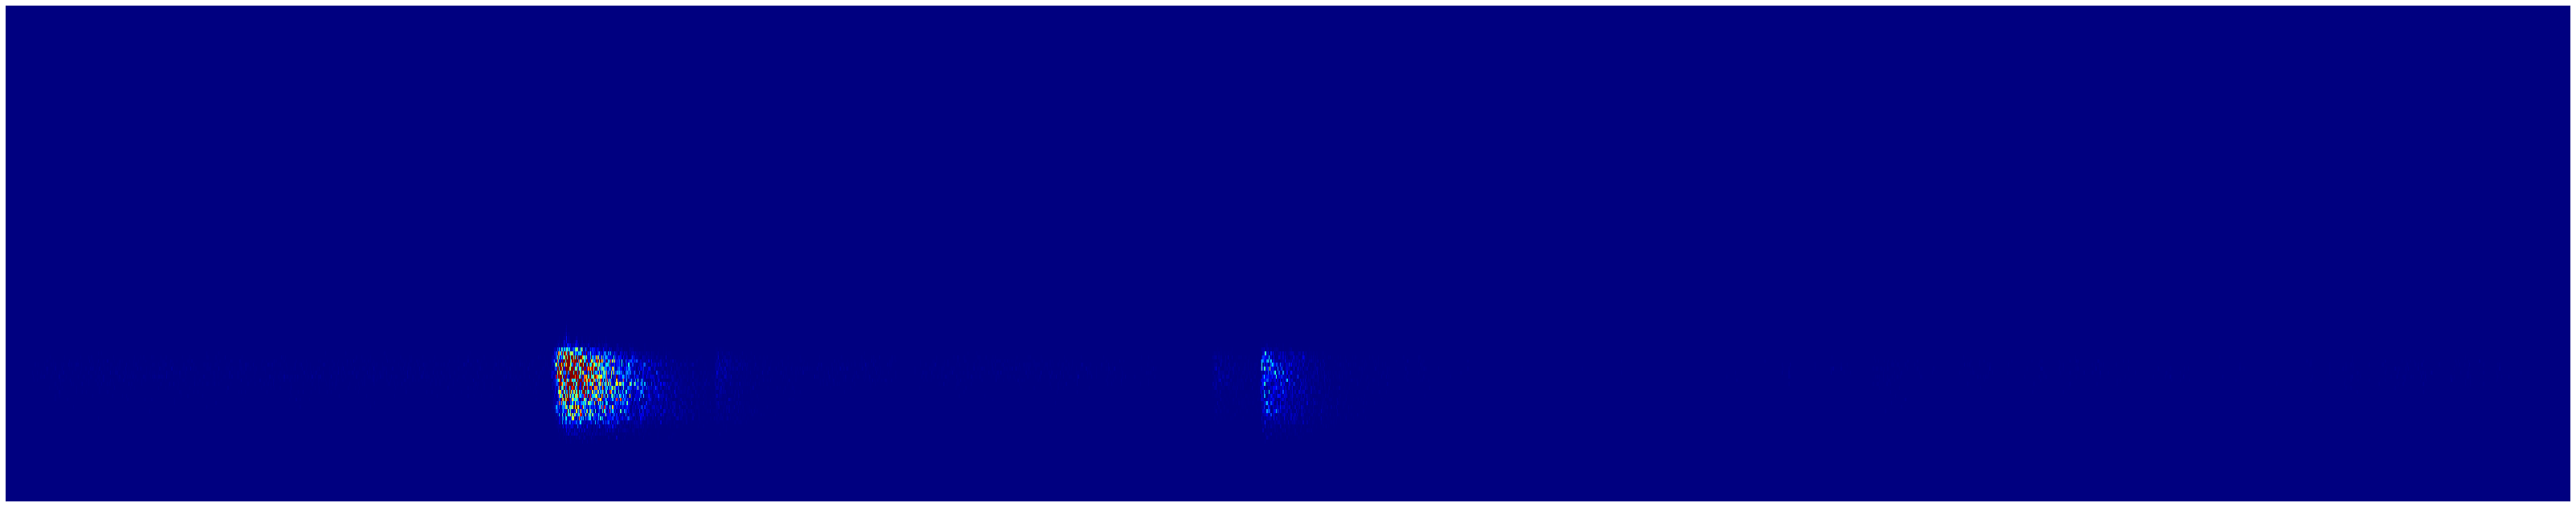

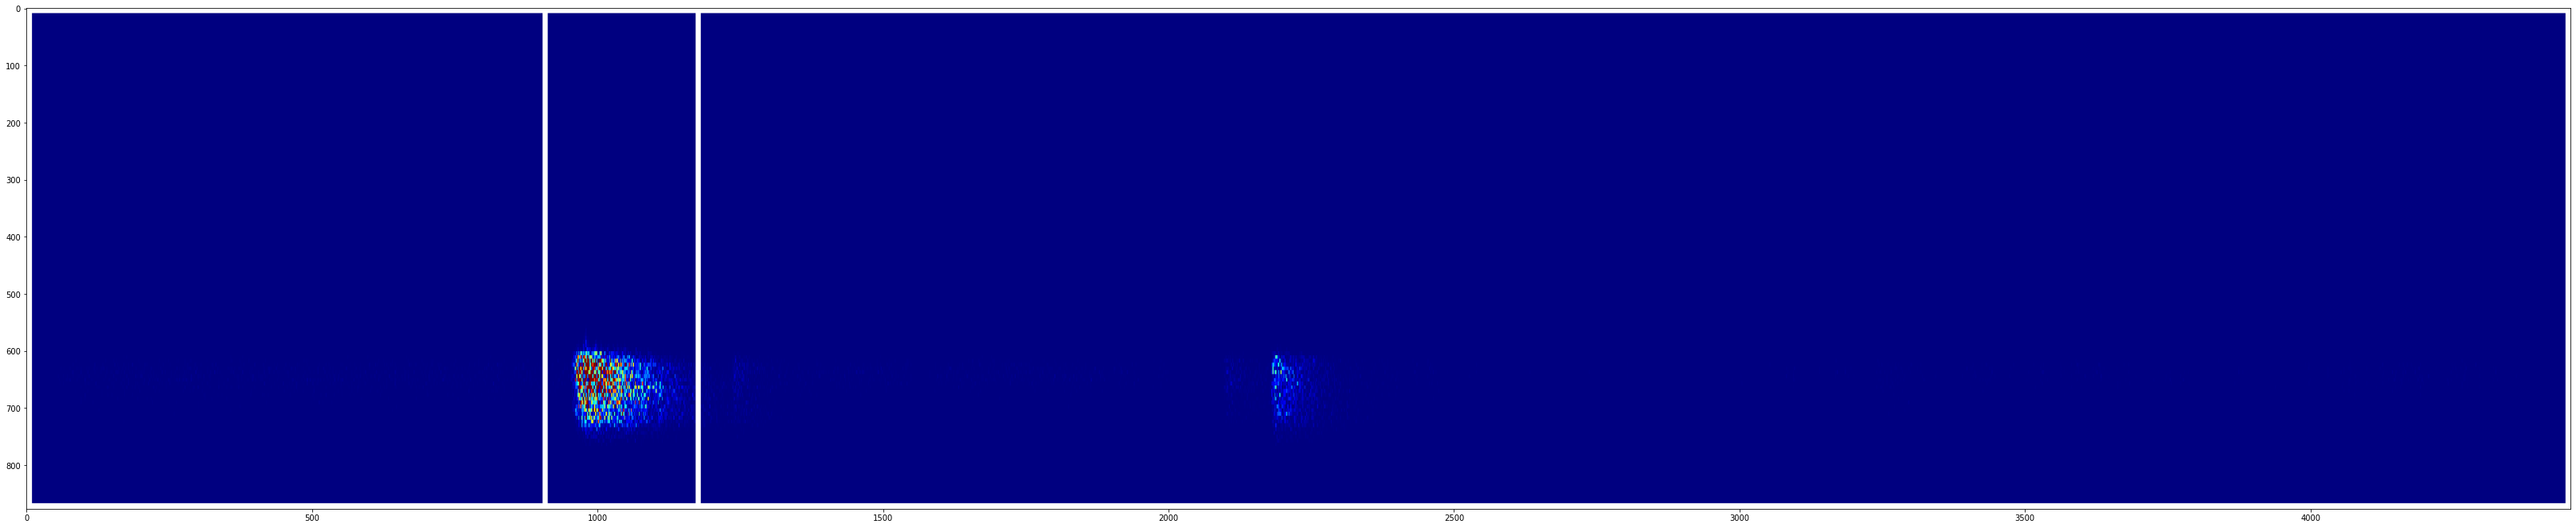

(572411,) (572411,)
17606.05264049321 22802.552759052876
Predição:17606.05264049321
Arrival: 18359.513


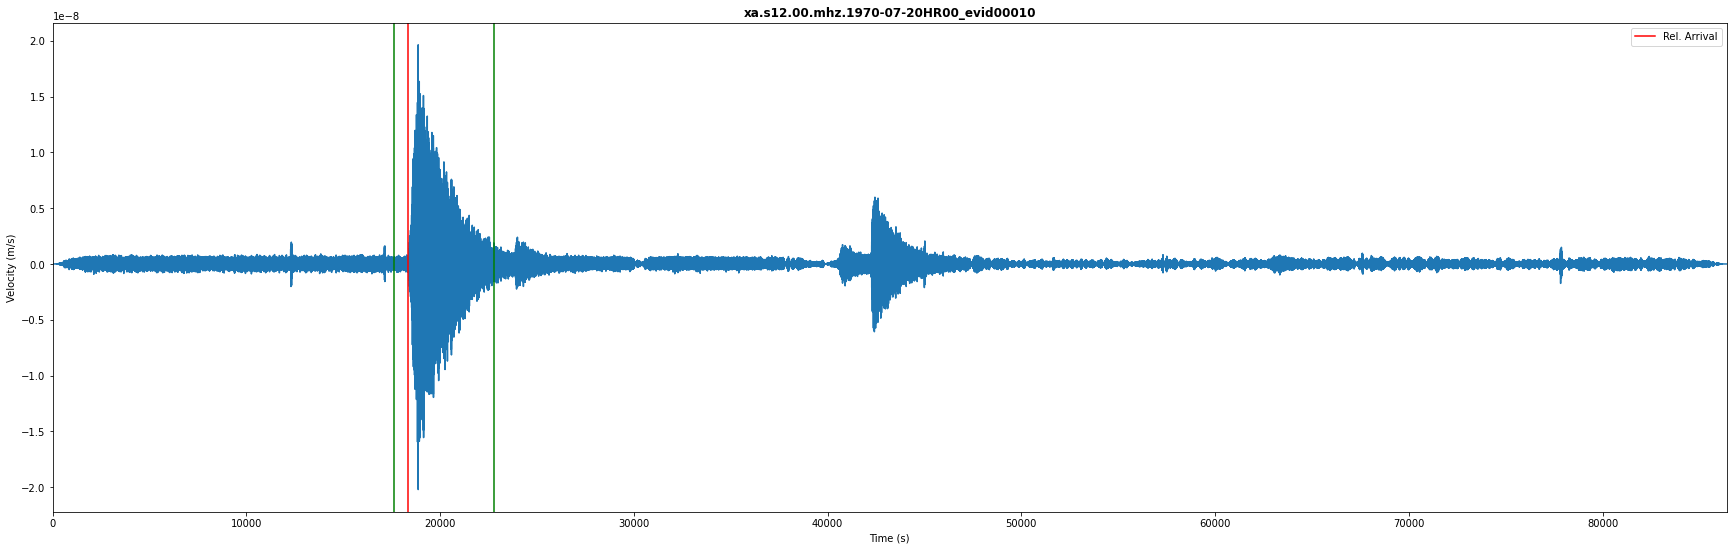

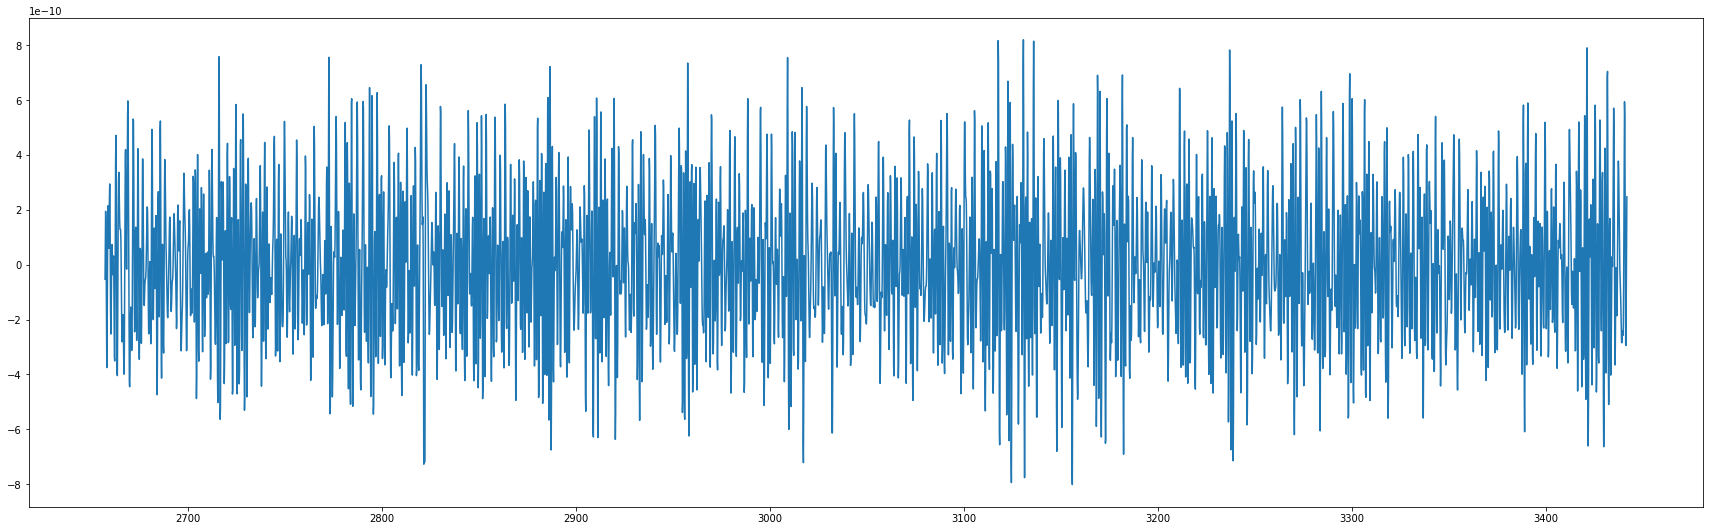

In [3]:
row = cat.iloc[7]

test_filename = row.filename
test_filename
    
arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'],'%Y-%m-%dT%H:%M:%S.%f')
arrival_time_rel = row['time_rel(sec)']

data_directory = './data/lunar/training/data/S12_GradeA/'
csv_file = f'{data_directory}{test_filename}.csv'
data_cat = pd.read_csv(csv_file)

test_filename = row.filename
data_directory = './data/lunar/training/data/S12_GradeA/'
mseed_file = f'{data_directory}{test_filename}.mseed'
    
try:
    st = read(mseed_file)
except FileNotFoundError:
    print(f'file {mseed_file} not found')
    iterator += 1
    pass
    
# This is how you get the data and the time, which is in seconds
tr = st.traces[0].copy()
tr_times = tr.times()
tr_data = tr.data

# Start time of trace (another way to get the relative arrival time using datetime)
starttime = tr.stats.starttime.datetime
arrival = (arrival_time - starttime).total_seconds()
    
# Set the minimum frequency
minfreq = 0.5
maxfreq = 1.0

# Going to create a separate trace for the filter data
st_filt = st.copy()
st_filt.filter('bandpass',freqmin=minfreq,freqmax=maxfreq)
tr_filt = st_filt.traces[0].copy()
tr_times_filt = tr_filt.times()
tr_data_filt = tr_filt.data
    
f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate)
    
width = st[0].stats['npts']/10000

fig = plt.figure(figsize=(width, 25), frameon = False)

ax2 = plt.subplot(2, 1, 2)
ax2.set_axis_off()
vals = ax2.pcolormesh(t, f, sxx, cmap=cm.jet, vmax=5e-17)
 
# Set the output file name and path
filename = 'espectrograma.png'

# Save the plot to the file
#plt.axis('off')
ax2 = plt.savefig(filename, dpi = 100, bbox_inches='tight')
    
img_color = cv.imread('my_plot.png')
img = cv.cvtColor(img_color, cv.COLOR_RGB2GRAY)

kernel = np.ones((12,12), np.uint8)
dilation = cv.dilate(img, kernel, iterations = 10)
    
# Threshold it so it becomes binary
ret, thresh = cv.threshold(dilation,0,255,cv.THRESH_BINARY+cv.THRESH_OTSU)

# Use connectedComponents() (returns a labeled image and the number of labels)
num_labels, labels = cv.connectedComponents(thresh)

# Use connectedComponentsWithStats() (returns a labeled image, the number of labels, and statistics for each component)
num_labels, labels, stats, centroids = cv.connectedComponentsWithStats(thresh)
    
nb_components, output, stats, centroids = cv.connectedComponentsWithStats(thresh, connectivity=4)
sizes = stats[:, -1]
    
max_label = 2
max_size = sizes[-1]

for i in range(2, nb_components):
    if sizes[i] > max_size:
        max_label = i
        max_size = sizes[i]

img2 = np.zeros(thresh.shape)
    
img2[output == max_label] = 255
    
if max_label >= nb_components:
    max_label = 1
    
x = stats[max_label, cv.CC_STAT_LEFT]
y = stats[max_label, cv.CC_STAT_TOP]
w = stats[max_label, cv.CC_STAT_WIDTH]
h = stats[max_label, cv.CC_STAT_HEIGHT]
    
i = 0
j = x

while i < img2.shape[0] and j + w < img2.shape[1]:
    img_color[i][j] = np.uint8(255)
    img_color[i][j-1] = np.uint8(255)
    img_color[i][j+1] = np.uint8(255)
    img_color[i][j-2] = np.uint8(255)
    img_color[i][j+2] = np.uint8(255)
    img_color[i][j-3] = np.uint8(255)
    img_color[i][j+3] = np.uint8(255)
    img_color[i][j-4] = np.uint8(255)
    img_color[i][j+4] = np.uint8(255)
    img_color[i][j+w] = np.uint8(255)
    img_color[i][j+w-1] = np.uint8(255)
    img_color[i][j+w+1] = np.uint8(255)
    img_color[i][j+w-2] = np.uint8(255)
    img_color[i][j+w+2] = np.uint8(255)
    img_color[i][j+w-3] = np.uint8(255)
    img_color[i][j+w+3] = np.uint8(255)
    img_color[i][j+w-4] = np.uint8(255)
    img_color[i][j+w+4] = np.uint8(255)
    i += 1
    
fig = plt.figure(figsize=(width, 25))
    
img_color = cv.cvtColor(img_color, cv.COLOR_BGR2RGB)
    
plt.imshow(img_color)

# Show the plot
plt.show()

# Read in time steps and velocities
csv_times = np.array(data_cat['time_rel(sec)'].tolist())
csv_data = np.array(data_cat['velocity(m/s)'].tolist())

# Plot the trace! 
fig,ax = plt.subplots(1,1,figsize=(30,9))
ax.plot(csv_times,csv_data)

# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
pred_line = ax.axvline(x= (j / img.shape[1]) * max(tr_times_filt), c='green', label='Rel. Arrival')
pred_line_end = ax.axvline(x= ((j + w) / img.shape[1]) * max(tr_times_filt), c='green', label='Rel. Arrival')
ax.legend(handles=[arrival_line])

print(csv_times.shape, csv_data.shape)

bnd1 = (j / img.shape[1]) * max(tr_times_filt)
bnd2 = (j + w) / img.shape[1] * max(tr_times_filt)

print(bnd1, bnd2)

fig,ax = plt.subplots(1,1,figsize=(30,9))
ax.plot(csv_times[int(bnd1): int(bnd2)],csv_data[int(bnd1): int(bnd2)])

'''
# Make the plot pretty
ax.set_xlim([min(csv_times),max(csv_times)])
ax.set_ylabel('Velocity (m/s)')
ax.set_xlabel('Time (s)')
ax.set_title(f'{test_filename}', fontweight='bold')

# Plot where the arrival time is
arrival_line = ax.axvline(x=arrival_time_rel, c='red', label='Rel. Arrival')
pred_line = ax.axvline(x= (j / img.shape[1]) * max(tr_times_filt), c='green', label='Rel. Arrival')
pred_line_end = ax.axvline(x= ((j + w) / img.shape[1]) * max(tr_times_filt), c='green', label='Rel. Arrival')
ax.legend(handles=[arrival_line])
'''
    
print(f'Predição:{(j / img.shape[1]) * max(tr_times_filt)}\nArrival: {arrival}')